0.9615384615384616
Epoch:0, Avg_Score:-886.9, Epsilon:1.00000
Epoch:1, Avg_Score:-751.2, Epsilon:0.98000
Epoch:2, Avg_Score:-1187.4, Epsilon:0.96040
Epoch:3, Avg_Score:-1675.4, Epsilon:0.94119
Epoch:4, Avg_Score:-1332.5, Epsilon:0.92237
Epoch:5, Avg_Score:-798.9, Epsilon:0.90392
Epoch:6, Avg_Score:-1695.8, Epsilon:0.88584
Epoch:7, Avg_Score:-1054.7, Epsilon:0.86813
Epoch:8, Avg_Score:-1453.0, Epsilon:0.85076
Epoch:9, Avg_Score:-946.3, Epsilon:0.83375
Epoch:10, Avg_Score:-866.8, Epsilon:0.81707
Epoch:11, Avg_Score:-752.8, Epsilon:0.80073
Epoch:12, Avg_Score:-1306.0, Epsilon:0.78472
Epoch:13, Avg_Score:-801.2, Epsilon:0.76902
Epoch:14, Avg_Score:-784.9, Epsilon:0.75364
Epoch:15, Avg_Score:-877.0, Epsilon:0.73857
Epoch:16, Avg_Score:-908.3, Epsilon:0.72380
Epoch:17, Avg_Score:-601.4, Epsilon:0.70932
Epoch:18, Avg_Score:-910.9, Epsilon:0.69514
Epoch:19, Avg_Score:-992.2, Epsilon:0.68123
Epoch:20, Avg_Score:-1040.3, Epsilon:0.66761
Epoch:21, Avg_Score:-735.5, Epsilon:0.65426
Epoch:22, Avg_S

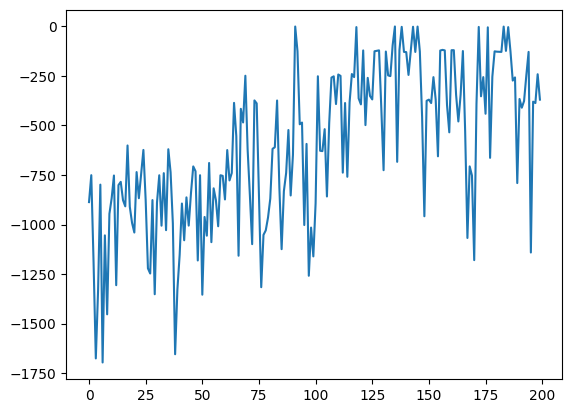

In [3]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Define the action transformation function
def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    linear_actions = np.linspace(-1, 1, n_actions)
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return scaled_actions

# Define the replay buffer class
class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        s_batch = torch.tensor(s_lst, dtype=torch.float)
        a_batch = torch.tensor(a_lst, dtype=torch.float)
        r_batch = torch.tensor(r_lst, dtype=torch.float)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float)
        done_batch = torch.tensor(done_mask_lst, dtype=torch.float)

        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def size(self):
        return len(self.buffer)

# Define the Q-network class
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, q_lr):
        super(QNetwork, self).__init__()
        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, action_dim)
        self.lr = q_lr
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        q = F.leaky_relu(self.fc_1(x))
        q = F.leaky_relu(self.fc_2(q))
        q = self.fc_out(q)
        return q

# Define the DQN agent class
class DQNAgent:
    def __init__(self, gamma_epoch):
        self.state_dim = 3
        self.action_dim = 11
        self.lr = 0.005
        self.gamma = (1-(1/gamma_epoch))
        self.epsilon = 1
        self.epsilon_decay = 0.98
        self.epsilon_min = 0.001
        self.buffer_size = 1000000
        self.batch_size = 256
        self.memory = ReplayBuffer(self.buffer_size)
        self.action_list = transform_action_values(self.action_dim, min_action=-2.0, max_action=2.0)
        self.Q = QNetwork(self.state_dim, self.action_dim, self.lr)
        print(self.gamma)
        
    def select_action(self, state):
        random_number = np.random.rand()
        if self.epsilon < random_number:
            with torch.no_grad():
                action = float(torch.argmax(self.Q(torch.FloatTensor(state))).numpy())
        else:
            action = float(np.random.choice([n for n in range(self.action_dim)]))
        real_action = self.action_list[int(action)]

        return action, real_action

    def calc_target(self, mini_batch):
        s, a, r, s_prime, done = mini_batch
        with torch.no_grad():
            q_target = self.Q(s_prime).max(1)[0].unsqueeze(1)
            target = r + self.gamma * done * q_target
        return target

    def train_agent(self):
        mini_batch = self.memory.sample(self.batch_size)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = mini_batch
        a_batch = a_batch.type(torch.int64)

        td_target = self.calc_target(mini_batch)

        Q_a = self.Q(s_batch).gather(1, a_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q.optimizer.step()

if __name__ == '__main__':
    agent = DQNAgent()
    env = gym.make('Pendulum-v1')

    EPOCHS = 200
    score_list = []

    while agent.memory.size() < 4 * agent.batch_size:
        state, info = env.reset()
        done = False

        while not done:
            action, real_action = agent.select_action(state)
            state_prime, reward, terminated, truncated, _ = env.step([real_action])

            if terminated or truncated:
                done = True

            agent.memory.put((state, action, reward, state_prime, terminated))
            state = state_prime

    for EP in range(EPOCHS):
        state, info = env.reset()
        score, done = 0.0, False

        while not done:
            action, real_action = agent.select_action(state)

            state_prime, reward, terminated, truncated, _ = env.step([real_action])
            agent.memory.put((state, action, reward, state_prime, terminated))

            agent.train_agent()

            if terminated or truncated:
                done = True

            score += reward

            state = state_prime

        print("Epoch:{}, Avg_Score:{:.1f}, Epsilon:{:.5f}".format(EP, score, agent.epsilon))
        score_list.append(score)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

    plt.plot(score_list)
    plt.show()
